In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

train = pd.read_csv('drive/MyDrive/HD_AI Challenge/open/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('drive/MyDrive/HD_AI Challenge/open/test.csv').drop(columns=['SAMPLE_ID'])

In [8]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 라벨 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'ID','SHIP_TYPE_CATEGORY' ,'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le


# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  4.93it/s]


In [9]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import math

train['IS_WEEKEND'] = train['weekday'].isin([4,5,6])
#train['TIME_OF_DAY'] = pd.cut(train['ATA_LT'], bins=[0, 6, 12, 18, 24], labels=[1, 2, 3, 4])
train['DIST_ZERO'] = train['DIST'].apply(lambda x: 0 if x == 0 else 1)
train['u*v_speed'] = train.apply(lambda row: math.sqrt(row['U_WIND']**2 + row['V_WIND']**2), axis=1)
train['CI_HOUR_Add'] = train['CI_HOUR'].apply(lambda x: 0 if x == 0 else 1)

test['IS_WEEKEND'] = test['weekday'].isin([4,5,6])
#train['TIME_OF_DAY'] = pd.cut(train['ATA_LT'], bins=[0, 6, 12, 18, 24], labels=[1, 2, 3, 4])
test['DIST_ZERO'] = test['DIST'].apply(lambda x: 0 if x == 0 else 1)
test['u*v_speed'] = test.apply(lambda row: math.sqrt(row['U_WIND']**2 + row['V_WIND']**2), axis=1)

train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,year,month,day,hour,minute,weekday,IS_WEEKEND,DIST_ZERO,u*v_speed,CI_HOUR_Add
0,4,13,0,30.736578,24337,30.0,28,73100,20.0,10.0,...,2020,10,15,4,3,3,False,1,3.772599,1
1,4,14,2,63.220425,19552,30.0,15,37900,20.0,10.0,...,2019,9,17,2,55,1,False,1,7.425901,1
2,4,45,2,90.427421,20449,50.0,7,115000,20.0,10.0,...,2019,2,23,6,43,5,True,1,0.000000,1
3,8,75,1,0.000000,1689,10.0,33,1490,10.0,0.0,...,2020,9,18,22,6,4,True,0,8.501276,0
4,16,46,2,8.813725,2989,30.0,10,27600,10.0,10.0,...,2022,8,13,12,57,5,True,1,3.003748,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,4,100,0,59.018184,9173,40.0,13,93200,20.0,10.0,...,2017,11,11,22,23,5,True,1,0.397119,1
367437,8,66,3,0.000000,3778,10.0,9,1280,0.0,0.0,...,2022,4,29,2,58,4,True,0,0.872067,0
367438,17,21,2,1.768630,15882,30.0,6,25000,20.0,10.0,...,2022,7,14,7,58,3,False,1,3.418552,1
367439,8,75,1,0.000000,12466,10.0,8,2400,10.0,0.0,...,2020,12,22,10,7,1,False,0,4.465557,0


In [10]:
# 데이터 분할을 위한 전처리
target = 'CI_HOUR_Add'
x = train.drop(labels=[target], axis = 1)
x = x.drop(labels='CI_HOUR', axis = 1)
y = train.loc[:, target]

from sklearn.preprocessing import StandardScaler

#MIN-MAX 스케일링
scaler = MinMaxScaler()

# train 데이터 스케일링 후 데이터 프라임으로 생성
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

# test 데이터 스케일링 후 데이터 프라임으로 생성
test = pd.DataFrame(scaler.fit_transform(test), columns=test.columns)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import *

from sklearn.neighbors import KNeighborsClassifier


# 데이터분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2)

# XGBoost 모델 생성
model1 = RandomForestClassifier()
# 모델 학습
model1.fit(x_train, y_train)

# 예측
pred = model1.predict(x_val)

# 성능 평가
print('Accuracy:', accuracy_score(y_val, pred))
print('=' * 60)
print('Confusion Matrix:')
print(confusion_matrix(y_val, pred))
print('=' * 60)
print('Classification Report:')
print(classification_report(y_val, pred))

Accuracy: 0.9999319626066486
Confusion Matrix:
[[29382     0]
 [    5 44102]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29382
           1       1.00      1.00      1.00     44107

    accuracy                           1.00     73489
   macro avg       1.00      1.00      1.00     73489
weighted avg       1.00      1.00      1.00     73489



In [12]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

In [13]:
ZERO_HOUR_data = train[train['CI_HOUR_Add'] == 0]

In [14]:
# CI_HOUR가 0이 나온 데이터 분할을 위한 전처리
target = 'CI_HOUR'
x = ZERO_HOUR_data.drop(labels=[target], axis = 1)
x = x.drop(labels='CI_HOUR_Add', axis = 1)
y = ZERO_HOUR_data.loc[:, target]
y

3         0.0
6         0.0
8         0.0
15        0.0
16        0.0
         ... 
367419    0.0
367431    0.0
367435    0.0
367437    0.0
367439    0.0
Name: CI_HOUR, Length: 147360, dtype: float64

In [15]:
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state=42)

# XGBoost 모델 생성
model2_1 = xgb.XGBClassifier()

# 모델 학습
model2_1.fit(x_train, y_train)

# 예측
pred = model2_1.predict(x_val)

# 성능 평가
print('Accuracy:', accuracy_score(y_val, pred))
print('=' * 60)
print('Confusion Matrix:')
print(confusion_matrix(y_val, pred))
print('=' * 60)
print('Classification Report:')
print(classification_report(y_val, pred))

Accuracy: 1.0
Confusion Matrix:
[[29472]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29472

    accuracy                           1.00     29472
   macro avg       1.00      1.00      1.00     29472
weighted avg       1.00      1.00      1.00     29472



In [16]:
NONZERO_HOUR_data = train[train['CI_HOUR_Add'] == 1]
NONZERO_HOUR_data

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,year,month,day,hour,minute,weekday,IS_WEEKEND,DIST_ZERO,u*v_speed,CI_HOUR_Add
0,4,13,0,30.736578,24337,30.0,28,73100,20.0,10.0,...,2020,10,15,4,3,3,False,1,3.772599,1
1,4,14,2,63.220425,19552,30.0,15,37900,20.0,10.0,...,2019,9,17,2,55,1,False,1,7.425901,1
2,4,45,2,90.427421,20449,50.0,7,115000,20.0,10.0,...,2019,2,23,6,43,5,True,1,0.000000,1
4,16,46,2,8.813725,2989,30.0,10,27600,10.0,10.0,...,2022,8,13,12,57,5,True,1,3.003748,1
5,4,45,2,81.435335,23924,30.0,22,18100,10.0,10.0,...,2015,9,8,14,24,1,False,1,0.397119,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367433,7,81,0,30.199074,23067,30.0,2,63500,20.0,10.0,...,2022,3,23,8,35,2,False,1,7.471814,1
367434,4,62,0,55.408765,3037,30.0,16,26500,10.0,10.0,...,2022,6,16,14,27,3,False,1,3.609986,1
367436,4,100,0,59.018184,9173,40.0,13,93200,20.0,10.0,...,2017,11,11,22,23,5,True,1,0.397119,1
367438,17,21,2,1.768630,15882,30.0,6,25000,20.0,10.0,...,2022,7,14,7,58,3,False,1,3.418552,1


In [17]:
# CI_HOUR가 0이 아닌 데이터 분할을 위한 전처리
target = 'CI_HOUR'
x = NONZERO_HOUR_data.drop(labels=[target], axis = 1)
x = x.drop(labels="CI_HOUR_Add", axis = 1)
y = NONZERO_HOUR_data.loc[:, target]
x

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,PORT_SIZE,year,month,day,hour,minute,weekday,IS_WEEKEND,DIST_ZERO,u*v_speed
0,4,13,0,30.736578,24337,30.0,28,73100,20.0,10.0,...,0.001660,2020,10,15,4,3,3,False,1,3.772599
1,4,14,2,63.220425,19552,30.0,15,37900,20.0,10.0,...,0.001614,2019,9,17,2,55,1,False,1,7.425901
2,4,45,2,90.427421,20449,50.0,7,115000,20.0,10.0,...,0.001743,2019,2,23,6,43,5,True,1,0.000000
4,16,46,2,8.813725,2989,30.0,10,27600,10.0,10.0,...,0.000197,2022,8,13,12,57,5,True,1,3.003748
5,4,45,2,81.435335,23924,30.0,22,18100,10.0,10.0,...,0.001743,2015,9,8,14,24,1,False,1,0.397119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367433,7,81,0,30.199074,23067,30.0,2,63500,20.0,10.0,...,0.000217,2022,3,23,8,35,2,False,1,7.471814
367434,4,62,0,55.408765,3037,30.0,16,26500,10.0,10.0,...,0.000595,2022,6,16,14,27,3,False,1,3.609986
367436,4,100,0,59.018184,9173,40.0,13,93200,20.0,10.0,...,0.000360,2017,11,11,22,23,5,True,1,0.397119
367438,17,21,2,1.768630,15882,30.0,6,25000,20.0,10.0,...,0.002615,2022,7,14,7,58,3,False,1,3.418552


Model Tune for LGBM.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4185
[LightGBM] [Info] Number of data points in the train set: 220081, number of used features: 33
[LightGBM] [Info] Start training from score 103.308282


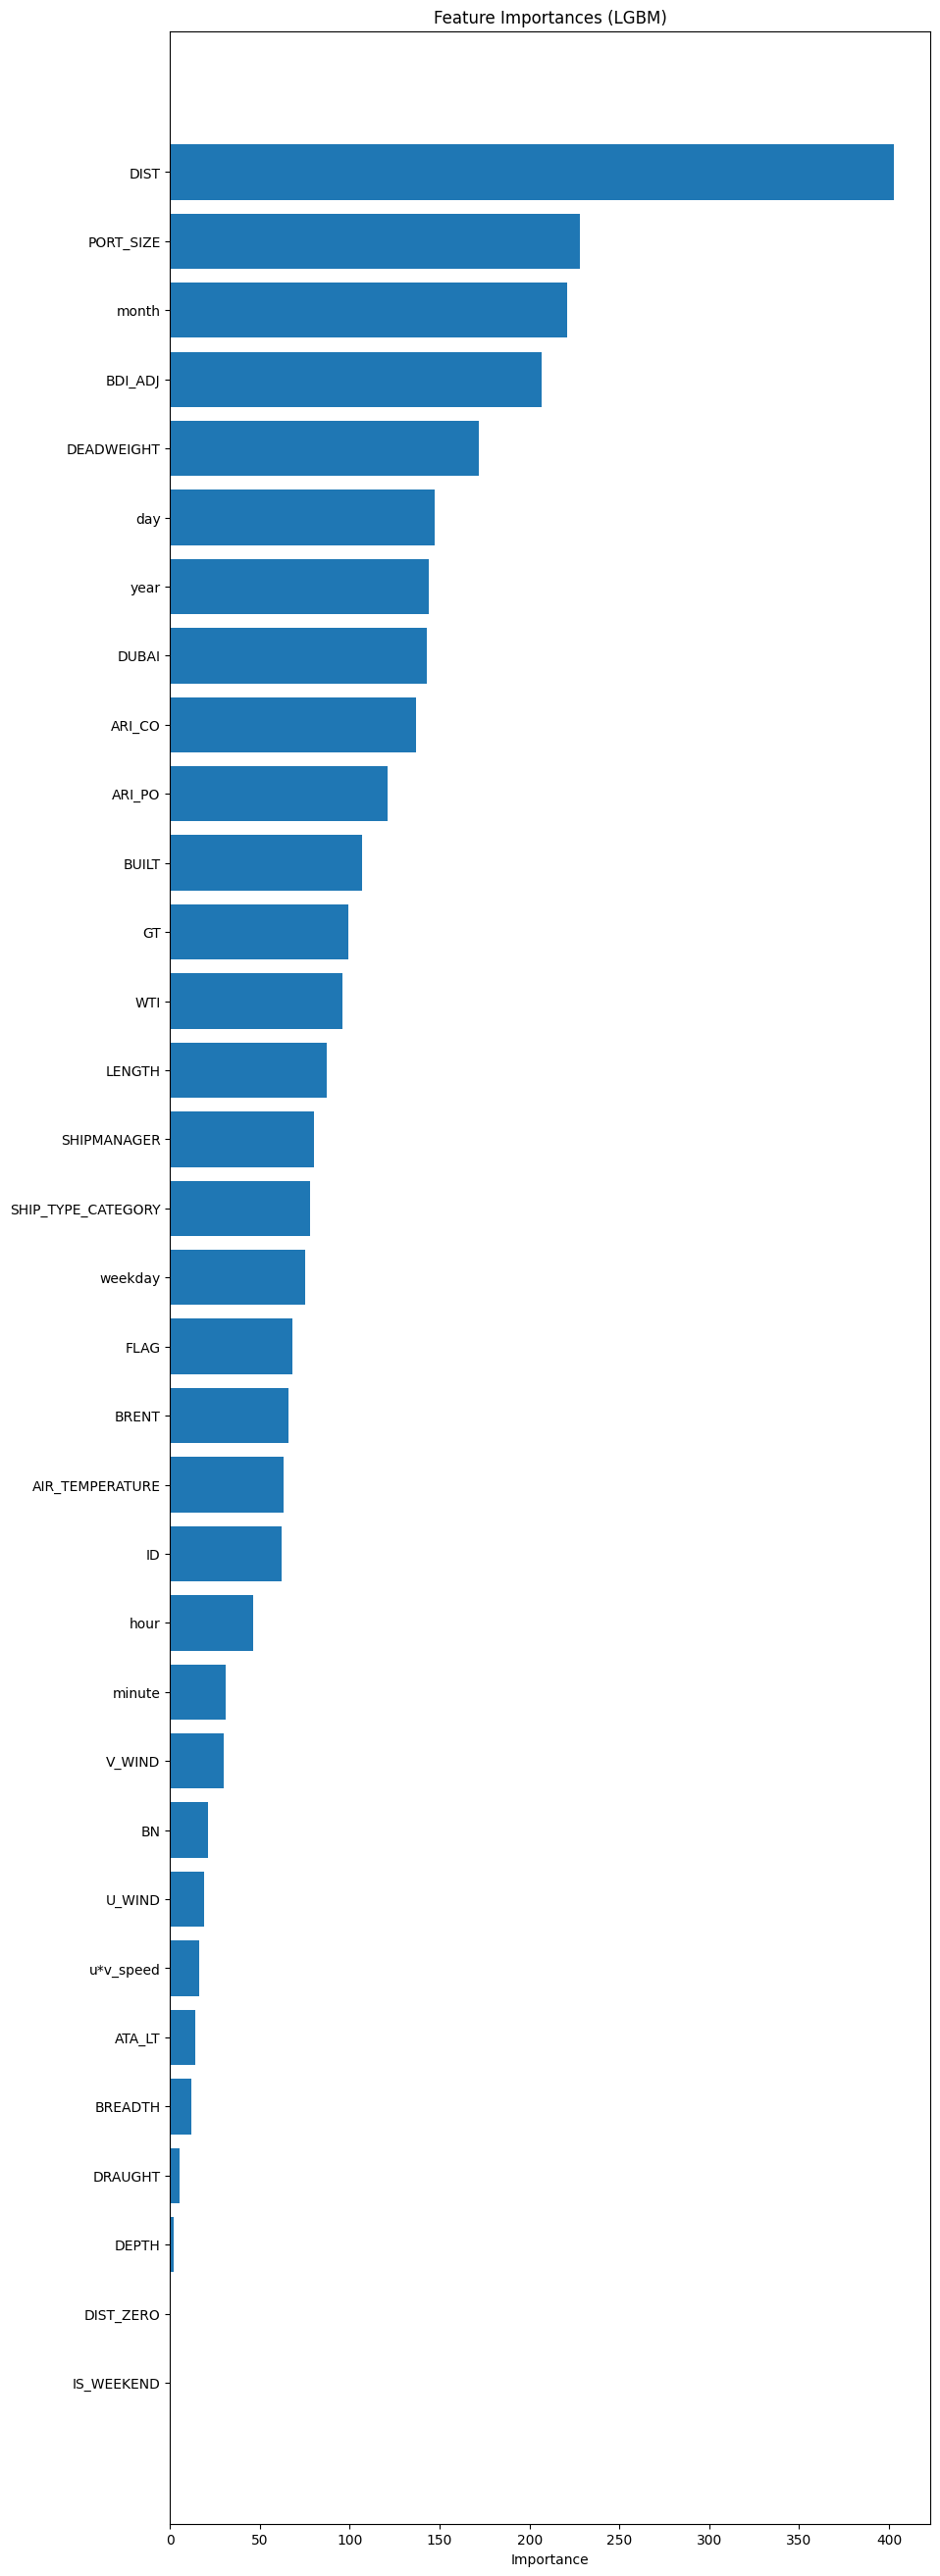

In [18]:
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)


X_train = x
y_train = y

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# LightGBM 모델 초기화
model2_2 = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient Boosting Decision Tree
    num_leaves=31,         # 트리의 최대 리프 노드 수
    learning_rate=0.05,    # 학습률
    n_estimators=10000       # 트리의 개수 (반복 횟수)
)

# 모델 학습
model2_2.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model2_2.predict(X_test)

# 평가 지표 계산 (예: 평균 제곱 오차, MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4183
[LightGBM] [Info] Number of data points in the train set: 176064, number of used features: 33
[LightGBM] [Info] Start training from score 103.102634
Mean Squared Error: 9895.998879203578


In [20]:
result = pd.concat([df1, df2], axis=0)

print(result)

In [21]:
# 모델1으로 시간 0 , 1 분류
pred = model1.predict(test)

# 0으로 예측된 데이터 추출
x_val_0 = test[pred == 0]
# 1로 예측된 데이터 추출
x_val_1 = test[pred == 1]

#분류된 모델로 2_1 , 2_2
pred2_1 = model2_1.predict(x_val_0)
pred2_2 = model2_2.predict(x_val_1)

In [40]:
df1 = x_val_0.assign(final_predictions =pred2_1)
df2 = x_val_1.assign(final_predictions =pred2_2)

dataframes = [df1, df2]
result = pd.concat(dataframes, axis=0)
result = result.sort_index()
final_predictions = result['final_predictions']
final_predictions

0          124.790520
1          280.726737
2            0.000000
3            0.000000
4           43.918552
             ...     
244984     256.990786
244985     392.582800
244986       0.000000
244987       0.000000
244988    1210.464973
Name: final_predictions, Length: 244989, dtype: float64

In [41]:
submit = pd.read_csv('drive/MyDrive/HD_AI Challenge/open/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('drive/MyDrive/HD_AI Challenge/open/baseline_submit.csv', index=False)